# cell 1 : Install packages

In [41]:
# pip install torch torchvision albumentations opencv-python matplotlib numpy pandas pycocotools

# cell 2 : Paths

In [42]:
import os
train_img_dir = "/home/saku/2010776109_RUSHO/RSOD_YOLO-20250708T170752Z-1-001/RSOD_YOLO/train/images"
train_ann_dir = "/home/saku/2010776109_RUSHO/RSOD_YOLO-20250708T170752Z-1-001/RSOD_YOLO/train/Annotations"
val_img_dir = "/home/saku/2010776109_RUSHO/RSOD_YOLO-20250708T170752Z-1-001/RSOD_YOLO/val/images"
val_ann_dir = "/home/saku/2010776109_RUSHO/RSOD_YOLO-20250708T170752Z-1-001/RSOD_YOLO/val/Annotations"

assert os.path.exists(train_img_dir) and os.path.exists(val_img_dir)
print("Paths verified") 

Paths verified


# Cell 3 : Clahe transform

In [43]:
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

class CLAHETransform(ImageOnlyTransform):
    def __init__(self, clip_limit=2.0, tile_grid_size=(8,8), always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size

    def apply(self, image, **params):
        lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        l,a,b = cv2.split(lab)
        clahe = cv2.createCLAHE(self.clip_limit, self.tile_grid_size)
        cl = clahe.apply(l)
        merged = cv2.merge((cl,a,b))
        return cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)

# CELL 4 ; TRANSFORM

In [44]:
# def get_train_transform() : 
#     return A.Compose([
#         CLAHETransform(),
#         A.RandomBrightnessContrast(0.2,0.2,p = 0.5), #Randomly adjusts image brightness and contrast within ±20%.
#         A.HorizontalFlip(p=0.5), #50% chance to flip the image horizontally.
#         A.RandomRotate90(p=0.5), #Randomly rotates the image by 90°, 180°, or 270°.
#         A.Resize(640,640),
#         A.Normalize(mean=[0.485,0.456,0.406], std = [0.229,0.224, 0.225]), #Standard ImageNet mean & std for normalization.

#     ],
#     bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
#     )
# def get_val_transform() : 
#     return A.Compose([
#         CLAHETransform(),
#         A.Resize(640,640),
#         A.Normalize(mean=[0.485,0.456,0.406], std = [0.229,0.224, 0.225]), #Standard ImageNet mean & std for normalization.

#     ],
#     bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
#     )

def get_train_transform():
    return A.Compose([
        CLAHETransform(),
        A.RandomBrightnessContrast(0.2,0.2,p=0.5),
        A.HorizontalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.Resize(640, 640),
        A.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

def get_val_transform():
    return A.Compose([
        CLAHETransform(),
        A.Resize(640, 640),
        A.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

# CELL 5 : DATASET CLASS

In [45]:
import torch
from torch.utils.data import Dataset
from glob import glob
import numpy as np
import xml.etree.ElementTree as ET
from PIL import Image

class RSODDataset(Dataset):
    def __init__(self, img_dir, ann_dir, transforms=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.transforms = transforms
        self.img_files = sorted(glob(os.path.join(img_dir, '*.jpg')) + glob(os.path.join(img_dir, '*.png')))
        self.class_dict = {"aircraft":1, "oiltank":2, "overpass":3, "playground":4}

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        image = np.array(Image.open(img_path).convert("RGB"))
        xml = os.path.join(self.ann_dir, os.path.basename(img_path).replace(".jpg", ".xml").replace(".png", ".xml"))
        root = ET.parse(xml).getroot()

        boxes, labels = [], []
        for obj in root.findall('object'):
            cls = obj.find('name').text.lower()
            if cls not in self.class_dict: continue
            bbox = obj.find('bndbox')
            xmin = float(bbox.find('xmin').text)
            ymin = float(bbox.find('ymin').text)
            xmax = float(bbox.find('xmax').text)
            ymax = float(bbox.find('ymax').text)
            boxes.append([xmin,ymin,xmax,ymax])
            labels.append(self.class_dict[cls])

        boxes = np.array(boxes, dtype=np.float32) if boxes else np.zeros((0,4))
        labels = np.array(labels) if labels else np.zeros(0,)

        if self.transforms:
            transformed = self.transforms(image=image, bboxes=boxes, labels=labels)
            image = transformed['image']
            boxes = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)
            labels = torch.as_tensor(transformed['labels'], dtype=torch.int64)

        return image, {'boxes': boxes, 'labels': labels}

train_dataset = RSODDataset(train_img_dir, train_ann_dir, get_train_transform())
val_dataset = RSODDataset(val_img_dir, val_ann_dir, get_val_transform())

# CELL 6 : RetinaNet Model(retinanet_resnet50_fpnv2())

In [46]:
from torchvision.models.detection import retinanet_resnet50_fpn_v2
from torchvision.models.detection.retinanet import RetinaNetClassificationHead

def get_model(num_classes):
    model = retinanet_resnet50_fpn_v2(pretrained=True)
    print(model.head.classification_head)
    in_feet = model.head.classification_head.conv[0][0].in_channels
    num_anchors = model.head.classification_head.num_anchors
    model.head.classification_head = RetinaNetClassificationHead(
        in_feet,num_anchors,num_classes
    )
    return model
model = get_model(num_classes=5)

/home/saku/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/saku/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RetinaNet_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=RetinaNet_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RetinaNetClassificationHead(
  (conv): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GroupNorm(32, 256, eps=1e-05, affine=True)
      (2): ReLU(inplace=True)
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GroupNorm(32, 256, eps=1e-05, affine=True)
      (2): ReLU(inplace=True)
    )
    (2): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GroupNorm(32, 256, eps=1e-05, affine=True)
      (2): ReLU(inplace=True)
    )
    (3): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GroupNorm(32, 256, eps=1e-05, affine=True)
      (2): ReLU(inplace=True)
    )
  )
  (cls_logits): Conv2d(256, 819, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


# CELL 7 : DATALOADERS , OPTIMIZER AND SCHEDULER

In [47]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2, collate_fn=collate_fn)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      

# CELL 8 : TRAIN AND VAL LOOP

In [48]:
import time

def train_one_epoch(model, optimizer, loader, device):
    model.train()
    total_loss = 0
    for imgs, targets in loader:
        imgs = [img.to(device) for img in imgs]
        targets = [{k:v.to(device) for k,v in t.items()} for t in targets]

        #expansion of above for loop
        # new_targets = []  # make a new list

        # for t in targets:
        #     new_t = {}  # new dict for this target
        #     for k, v in t.items():
        #         new_t[k] = v.to(device)  # move tensor to device
        #     new_targets.append(new_t)

        # targets = new_targets  # replace original targets


        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        #expansion of above 
        # Make a variable to store the total loss
        # total_loss = 0.0

        # # Loop through all the losses in the dictionary
        # for loss_name, loss_value in loss_dict.items():
        #     total_loss += loss_value  # add each loss to the total

        # # Store final sum in losses
        # losses = total_loss



        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_loss += losses.item()

    return total_loss / len(loader)

def evaluate(model, loader, device):
    model.train() 
    total_loss = 0
    with torch.no_grad():
        for imgs, targets in loader:
            imgs = [img.to(device) for img in imgs]
            targets = [{k:v.to(device) for k,v in t.items()} for t in targets]

            loss_dict = model(imgs, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()
    return total_loss / len(loader)

train_losses = []
val_losses = []
epoch_mAPs = []

num_epochs = 20
for epoch in range(num_epochs):
    t0 = time.time()
    train_loss = train_one_epoch(model, optimizer, train_loader, device)
    val_loss = evaluate(model, val_loader, device)
    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    epoch_mAPs.append(None)
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {time.time()-t0:.1f}s")

Epoch 1/20 | Train Loss: 1.2296 | Val Loss: 1.1066 | Time: 147.6s
Epoch 2/20 | Train Loss: 1.0206 | Val Loss: 1.1107 | Time: 151.4s
Epoch 3/20 | Train Loss: 0.7835 | Val Loss: 0.8673 | Time: 152.6s
Epoch 4/20 | Train Loss: 0.5495 | Val Loss: 0.4689 | Time: 153.1s
Epoch 5/20 | Train Loss: 0.4855 | Val Loss: 0.3734 | Time: 151.8s
Epoch 6/20 | Train Loss: 0.3445 | Val Loss: 0.3789 | Time: 148.5s
Epoch 7/20 | Train Loss: 0.2917 | Val Loss: 0.3088 | Time: 150.2s
Epoch 8/20 | Train Loss: 0.2641 | Val Loss: 0.2983 | Time: 152.3s
Epoch 9/20 | Train Loss: 0.2454 | Val Loss: 0.2834 | Time: 153.2s
Epoch 10/20 | Train Loss: 0.2397 | Val Loss: 0.3025 | Time: 151.7s
Epoch 11/20 | Train Loss: 0.2357 | Val Loss: 0.2727 | Time: 152.0s
Epoch 12/20 | Train Loss: 0.2142 | Val Loss: 0.2669 | Time: 152.8s
Epoch 13/20 | Train Loss: 0.2127 | Val Loss: 0.2639 | Time: 152.6s
Epoch 14/20 | Train Loss: 0.2021 | Val Loss: 0.2642 | Time: 153.4s
Epoch 15/20 | Train Loss: 0.1977 | Val Loss: 0.2560 | Time: 153.1s
Epoc

# please wait 

# CELL 9 : SAVE THE MODEL

In [49]:
torch.save(model.state_dict(), "retinanet_rsod.pth")

# CELL 10 : LOSS CURVES

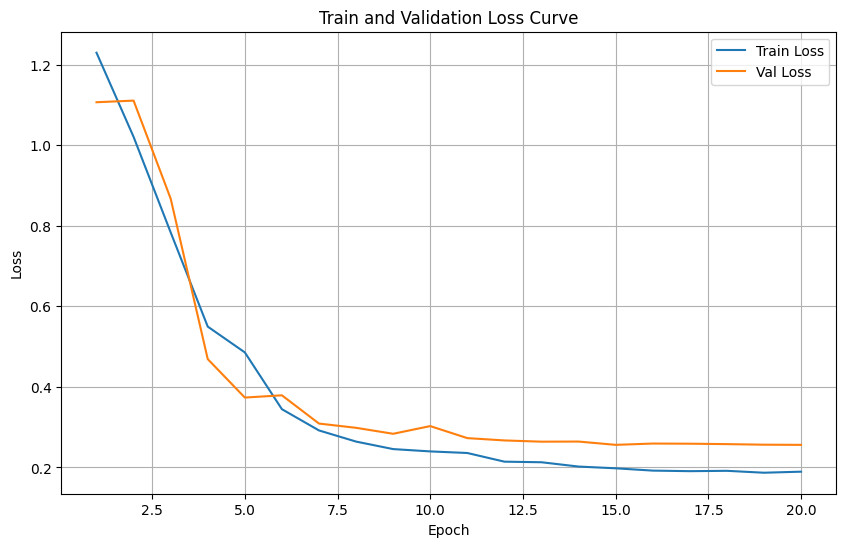

In [50]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(range(1,num_epochs+1), train_losses, label = "Train Loss")
plt.plot(range(1, num_epochs+1) , val_losses, label = "Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

# COCO mAP evaluation(per class AP and final mAP)

In [51]:
import gc
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# torch.cuda.empty_cache()
# gc.collect()


In [52]:
model.eval()
model.to(device)

model.score_thresh = 0.01 # lower score threshold for weak boxes

results = []
image_ids = []
with torch.no_grad():
    for idx, (imgs, targets) in enumerate(val_loader):
        imgs = [img.to(device) for img in imgs]
        outputs = model(imgs)

        for i, output in enumerate(outputs):
            boxes = output['boxes'].cpu().numpy()
            scores = output['scores'].cpu().numpy()
            labels = output['labels'].cpu().numpy()

            print(f"Image {idx*len(outputs)+i} — Boxes: {len(boxes)}, Avg Score: {scores.mean() if len(scores) else 0:.4f}")

            for k in range(len(boxes)):
                x1, y1, x2, y2 = boxes[k]
                results.append({
                    "image_id": idx*len(outputs)+i,
                    "category_id": int(labels[k]),
                    "bbox": [float(x1), float(y1), float(x2 - x1), float(y2 - y1)],
                    "score": float(scores[k])
                })
            image_ids.append(idx*len(outputs)+i)

print(f"___________Total predictions: {len(results)}_____________")


Image 0 — Boxes: 300, Avg Score: 0.0422
Image 1 — Boxes: 300, Avg Score: 0.0644
Image 2 — Boxes: 300, Avg Score: 0.0409
Image 3 — Boxes: 300, Avg Score: 0.1039
Image 4 — Boxes: 300, Avg Score: 0.0589
Image 5 — Boxes: 300, Avg Score: 0.0412
Image 6 — Boxes: 300, Avg Score: 0.0801
Image 7 — Boxes: 300, Avg Score: 0.1681
Image 8 — Boxes: 300, Avg Score: 0.0745
Image 9 — Boxes: 300, Avg Score: 0.0945
Image 10 — Boxes: 300, Avg Score: 0.0523
Image 11 — Boxes: 300, Avg Score: 0.0585
Image 12 — Boxes: 300, Avg Score: 0.0738
Image 13 — Boxes: 300, Avg Score: 0.1093
Image 14 — Boxes: 300, Avg Score: 0.0584
Image 15 — Boxes: 300, Avg Score: 0.0976
Image 16 — Boxes: 300, Avg Score: 0.0526
Image 17 — Boxes: 300, Avg Score: 0.0596
Image 18 — Boxes: 300, Avg Score: 0.0343
Image 19 — Boxes: 300, Avg Score: 0.0925
Image 20 — Boxes: 300, Avg Score: 0.0583
Image 21 — Boxes: 300, Avg Score: 0.0954
Image 22 — Boxes: 300, Avg Score: 0.0636
Image 23 — Boxes: 300, Avg Score: 0.0492
Image 24 — Boxes: 300, Avg

# save predictions JSON

In [53]:
with open("retina_predictions.json","w") as f:
    json.dump(results, f)

# COCO GT annotations dict

In [54]:
coco_gt = COCO()
dataset = {
    "info": {}, "licenses": [],
    "images": [{"id": i} for i in range(len(val_dataset))],
    "categories": [
        {"id": 1, "name": "aircraft"},
        {"id": 2, "name": "oiltank"},
        {"id": 3, "name": "overpass"},
        {"id": 4, "name": "playground"}
    ],
    "annotations": []
}

ann_id = 0
for img_id in range(len(val_dataset)):
    _, target = val_dataset[img_id]
    boxes = target['boxes'].numpy()
    labels = target['labels'].numpy()

    for k in range(len(boxes)):
        x1, y1, x2, y2 = boxes[k]
        dataset['annotations'].append({
            "id": ann_id,
            "image_id": img_id,
            "category_id": int(labels[k]),
            "bbox": [float(x1), float(y1), float(x2 - x1), float(y2 - y1)],
            "area": float((x2 - x1) * (y2 - y1)),
            "iscrowd": 0
        })
        ann_id += 1

coco_gt.dataset = dataset
coco_gt.createIndex()

creating index...
index created!


# Run COCO eval

In [55]:
coco_dt = coco_gt.loadRes("retina_predictions.json")
coco_eval = COCOeval(coco_gt, coco_dt, "bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

Loading and preparing results...
DONE (t=0.34s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.61s).
Accumulating evaluation results...
DONE (t=0.19s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.683
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.954
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.804
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.509
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.744
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.732
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.393
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.658
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.754
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

# Per-class AP@0.5

In [56]:
class_names = ["aircraft", "oiltank", "overpass", "playground"]
class_aps = {}
for i, name in enumerate(class_names, 1):
    coco_eval.params.catIds = [i]
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    class_aps[name] = coco_eval.stats[1]  # AP@0.5

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=1.12s).
Accumulating evaluation results...
DONE (t=0.09s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.648
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.942
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.791
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.509
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.727
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.903
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.073
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.495
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.698
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.592
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100

# per clas ap

In [57]:
print("\n Per-class AP@0.5:")
for k, v in class_aps.items():
    print(f"{k}: {v:.4f}")


 Per-class AP@0.5:
aircraft: 0.9417
oiltank: 0.9794
overpass: 0.9571
playground: 0.9363


# Final total mAP@0.5

In [58]:
total_map_50 = sum(class_aps.values()) / len(class_aps)
print(f"\nFINAL mAP@0.5: {total_map_50:.4f}")


FINAL mAP@0.5: 0.9536


# mAP vs Epoch

In [59]:
final_map = coco_eval.stats[1]
print(f"\n✅ Final mAP@0.5: {final_map:.4f}")

# Fill last epoch mAP (overwrite None)
epoch_mAPs[-1] = final_map

# If you tracked mAP every epoch, use that instead.



✅ Final mAP@0.5: 0.9363


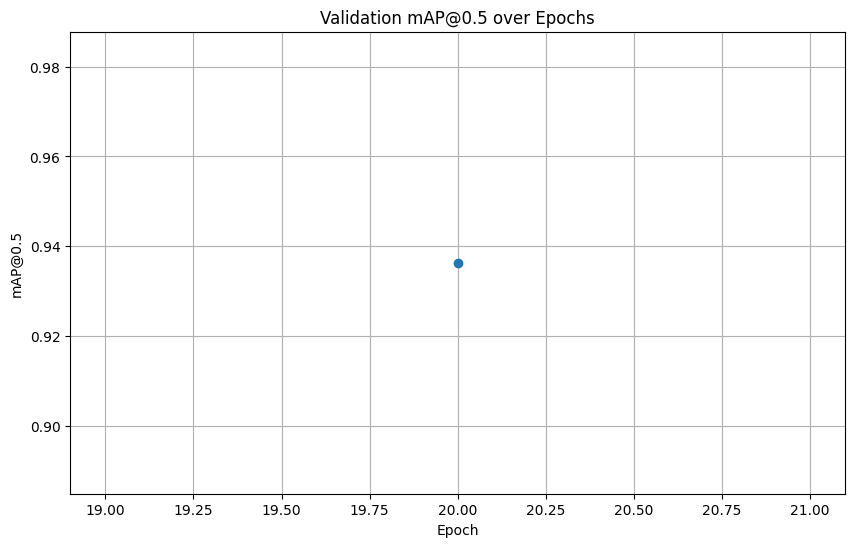

In [62]:
plt.figure(figsize=(10,6))
plt.plot(range(1, num_epochs+1), epoch_mAPs, marker='o')
plt.xlabel('Epoch')
plt.ylabel('mAP@0.5')
plt.title('Validation mAP@0.5 over Epochs')
plt.grid(True)
plt.show()


# Confusion Matrix

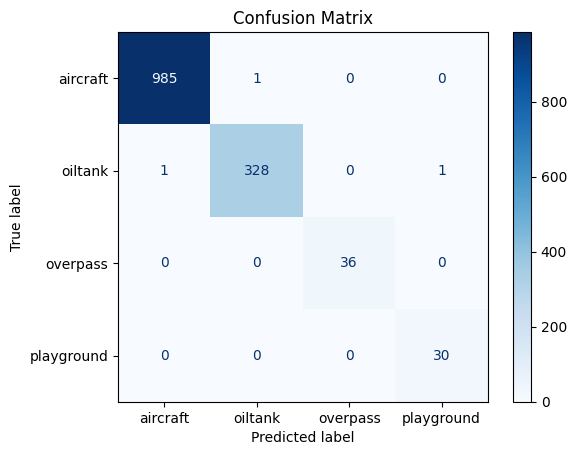

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Generate GT & predicted labels
y_true, y_pred = [], []

model.eval()
with torch.no_grad():
    for imgs, targets in val_loader:
        imgs = [img.to(device) for img in imgs]
        outputs = model(imgs)
        
        for i, output in enumerate(outputs):
            pred_labels = output['labels'].cpu().numpy()
            gt_labels = targets[i]['labels'].cpu().numpy()
            
            y_true.extend(gt_labels)
            y_pred.extend(pred_labels[:len(gt_labels)])  # assume top-N match

cm = confusion_matrix(y_true, y_pred, labels=[1,2,3,4])
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


# Show Predictions

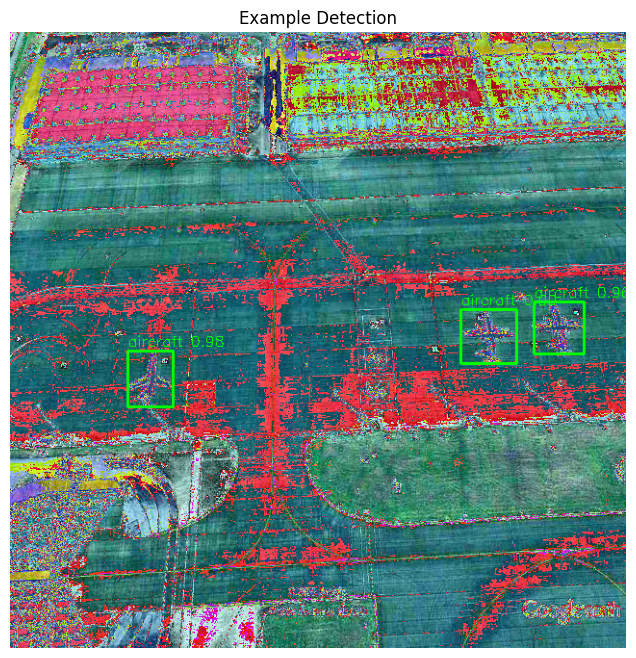

In [64]:
import torchvision.transforms.functional as F
import cv2

model.eval()
imgs, _ = next(iter(val_loader))
img = imgs[0].to(device)

with torch.no_grad():
    output = model([img])[0]

boxes = output['boxes'].cpu().numpy()
labels = output['labels'].cpu().numpy()
scores = output['scores'].cpu().numpy()

img = F.to_pil_image(img.cpu())
img_cv = np.array(img)

for box, label, score in zip(boxes, labels, scores):
    if score < 0.5:
        continue
    x1, y1, x2, y2 = map(int, box)
    cv2.rectangle(img_cv, (x1, y1), (x2, y2), (0,255,0), 2)
    cv2.putText(img_cv, f"{class_names[label-1]} {score:.2f}", (x1, y1-5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)

plt.figure(figsize=(8,8))
plt.imshow(img_cv)
plt.axis('off')
plt.title('Example Detection')
plt.show()
